# Timeseries Analysis: Bitcoin forescasting using seasonality decomposition

Romain Vie et Fabrice Mlili

In [1]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

KeyboardInterrupt: 

We read the csv and make a dataframe with date in index and price 

In [ ]:
df = pd.read_csv("BTC_1m_binance.csv").iloc[-130000:]
df["date"] = pd.to_datetime(df['closeTimestamp']+1, unit='ms')
df = df.set_index("date")
df['price'] = df['close']
df = df.price
df.head()

date
2022-07-19 23:48:00    23340.47
2022-07-19 23:49:00    23339.88
2022-07-19 23:50:00    23321.95
2022-07-19 23:51:00    23369.39
2022-07-19 23:52:00    23391.13
Name: price, dtype: float64

Here, we have price at each minute. For obtain easily a long-term forecast, we decided to resampled price to 1 day taking the mean price.

In [ ]:
df = df.resample("1D").mean()

In [ ]:
fig = px.line(df, y="price")
fig.show()


It seems there isn't seasonality and trends components. But with statsmodels library we check this.

In [ ]:
SD_multiplicative = seasonal_decompose(df, model='multiplicative', period=1)
SD_additive = seasonal_decompose(df, model='additive', period=1)

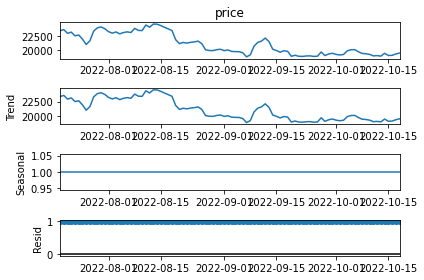

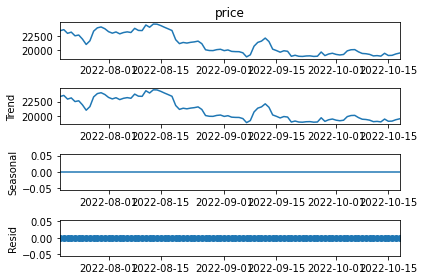

In [ ]:
SD_multiplicative.plot()
plt.show()
SD_additive.plot()
plt.show()

For the two types of decomposition, there isn't seonality. The trend is exactly the same that the price, this means we need to check if the trend component is time-dependent (using rolling stat, for example). And there is also residual component. \
\
Rolling statistics: Plot the moving average and moving standard deviation.\
The time series is stationary if it remains constant over time (by eye, look to see if the lines are straight and parallel to the x-axis)

### Perform moving average to look at the influence of time over the trend

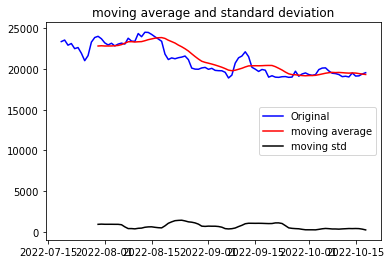

In [ ]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'moving average')
plt.plot(rolling_std, color = 'black', label = 'moving std')
plt.legend(loc = 'best')
plt.title('moving average and standard deviation')
plt.show()

As you can see, the moving average decreases with time. We can therefore conclude that the time series is not stationary (there is time-depencies).

Now, we're going to detrend the series to make it stationary using the same moving average that above avoiding over differencing.

### Detrend by moving average

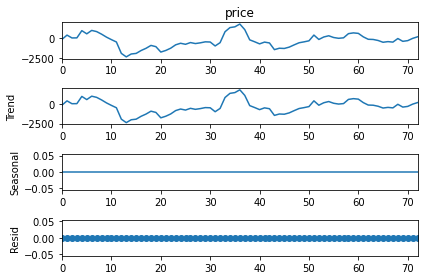

In [ ]:
df_detrend = (df - df.rolling(12).mean())[19:].reset_index(drop=True)

SD_additive = seasonal_decompose(df_detrend, model='additive', period=1)

plt.show()
SD_additive.plot()
plt.show()

For forecasting, we need make sure that the residual component is stationary, it hasn't time dependency. Graphically, they are some trends through time, so it seems the TS is not stationary, but we decided to perform a test.

### Perform augmented Dickey-Fuller stationary test

H0: the TS is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time. \
H1: the TS is stationary 

In [ ]:
result = adfuller(df_detrend, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.922811898819839
n_lags: 0.042758866670184296
p-value: 0.042758866670184296
Critial Values:
   1%, -3.526004646825607
Critial Values:
   5%, -2.9032002348069774
Critial Values:
   10%, -2.5889948363419957


p-value = 0.028 < 0.05 \
We succeed to reject the hypothesis H0 \
==> the time-series is stationary and thus there is no more time-dependancy to remove

### Forecasting using the model ARIMA

The model ARIMA is using for forecast time-series that have only a trend and a residual component. In the model, we need three hyperparameters: 

p is the order of the AR term 

q is the order of the MA term 

d is the number of differencing required to make the time series stationary

We already show that just one differencing makes the TS stationary. So we always need to find p and q. Plot the autocorrelation is the solution.

/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



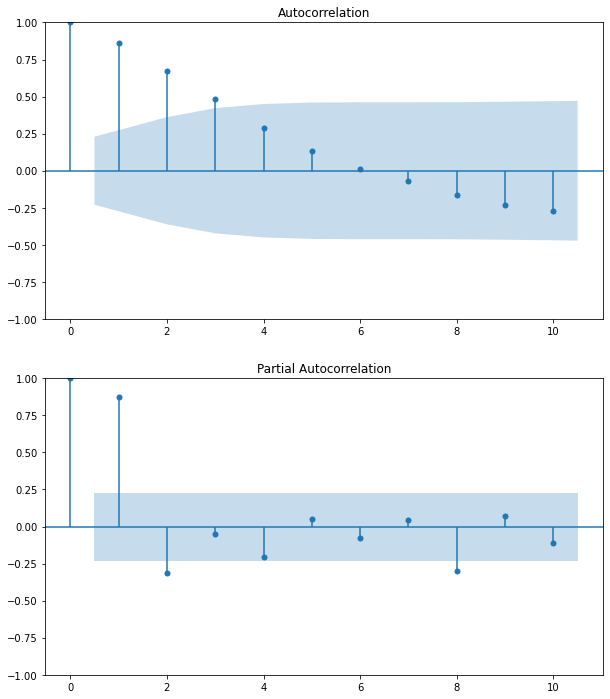

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
plot_acf(df_detrend, ax=ax[0], lags=10)
plot_pacf(df_detrend, ax=ax[1], lags=10)
plt.show()

The autocorrelation chart shows us that until 8 lags the correlation is significant, so we're going to give the value 8 to the q variable. \
The partial autocorrelation chart gives us two lags far away of blue zone, thus we take p = 2 as order of Auto Regression.  

Now, it's time to fit and predict with the model.

In [ ]:
TRAIN_SPLIT = int(df.shape[0] * 0.9)

train, test = df.iloc[:TRAIN_SPLIT], df.iloc[TRAIN_SPLIT:]

model = ARIMA(train, order=(8, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   82
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -610.336
Date:                Sun, 13 Nov 2022   AIC                           1242.672
Time:                        18:35:14   BIC                           1269.011
Sample:                    07-19-2022   HQIC                          1253.239
                         - 10-08-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0532      0.574      0.093      0.926      -1.071       1.178
ar.L2          0.5608      0.459      1.223      0.221      -0.338       1.460
ar.L3         -0.0543      0.134     -0.407      0.6

In [ ]:
pred = model_fit.predict(TRAIN_SPLIT, len(df)-1)
print(pred, test)
error = mean_squared_error(test, pred)
print("error: ", error)

2022-10-09    19507.400420
2022-10-10    19438.367177
2022-10-11    19474.812566
2022-10-12    19544.298073
2022-10-13    19596.112570
2022-10-14    19657.505625
2022-10-15    19640.683805
2022-10-16    19624.395111
2022-10-17    19612.191805
2022-10-18    19587.498031
Freq: D, Name: predicted_mean, dtype: float64 date
2022-10-09    19442.085458
2022-10-10    19326.547500
2022-10-11    19069.116528
2022-10-12    19118.383312
2022-10-13    19030.618021
2022-10-14    19515.856271
2022-10-15    19140.403667
2022-10-16    19164.884319
2022-10-17    19398.349694
2022-10-18    19552.738067
Freq: D, Name: price, dtype: float64
error:  121097.8055832686


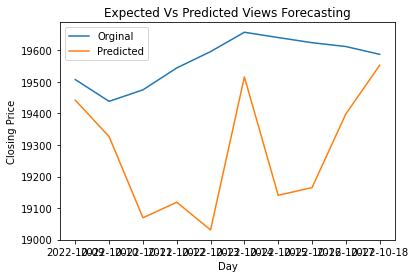

In [ ]:
labels={'Orginal','Predicted'}
plt.plot(pred)
plt.plot(test)
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

As you can see, the predictions are really not goods. Another solution to make forecasting more precise is to predict day by day, that is we use train to predict just the next day.

In [ ]:
TRAIN_SPLIT = int(df.shape[0] * 0.7)
train, test = df.iloc[:TRAIN_SPLIT], df.iloc[TRAIN_SPLIT:]
predictions = []
for i in range(len(test)):

    train, test = df.iloc[:TRAIN_SPLIT+i], df.iloc[TRAIN_SPLIT+i:]

    model = ARIMA(train, order=(8, 1, 2))
    model_fit = model.fit()
    pred = model_fit.predict(TRAIN_SPLIT+i, len(df)-1)
    predictions.append(pred[0])

train, test = df.iloc[:TRAIN_SPLIT], df.iloc[TRAIN_SPLIT:]


/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/fabrice/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization f

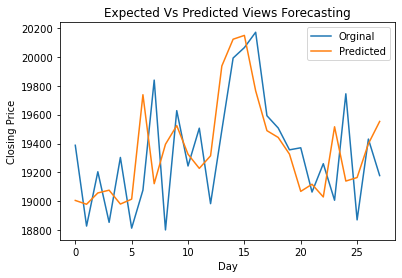

In [ ]:
labels={'Orginal','Predicted'}
plt.plot(predictions)
plt.plot(test.values)
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

The resultat is significantly better but far to be perfect. We can conclude that forecast the price of bitcoin is a very hard task to do. If the price was easily to  forecast, anyone could become rich.